1: split slides into cohorts based on sample type and stain type

2: get tissue pixel count

2.9: (likely some sort of preprocessing/normalization to consistently find folds)

3: find folds

4: Dust finder

5: Custom deconv (difference from pregen marked against it?)

6?: blur detection

7: stain haze detection

8: stitching artifacts

# wait and show results of each step

(23164, 24089, 3)


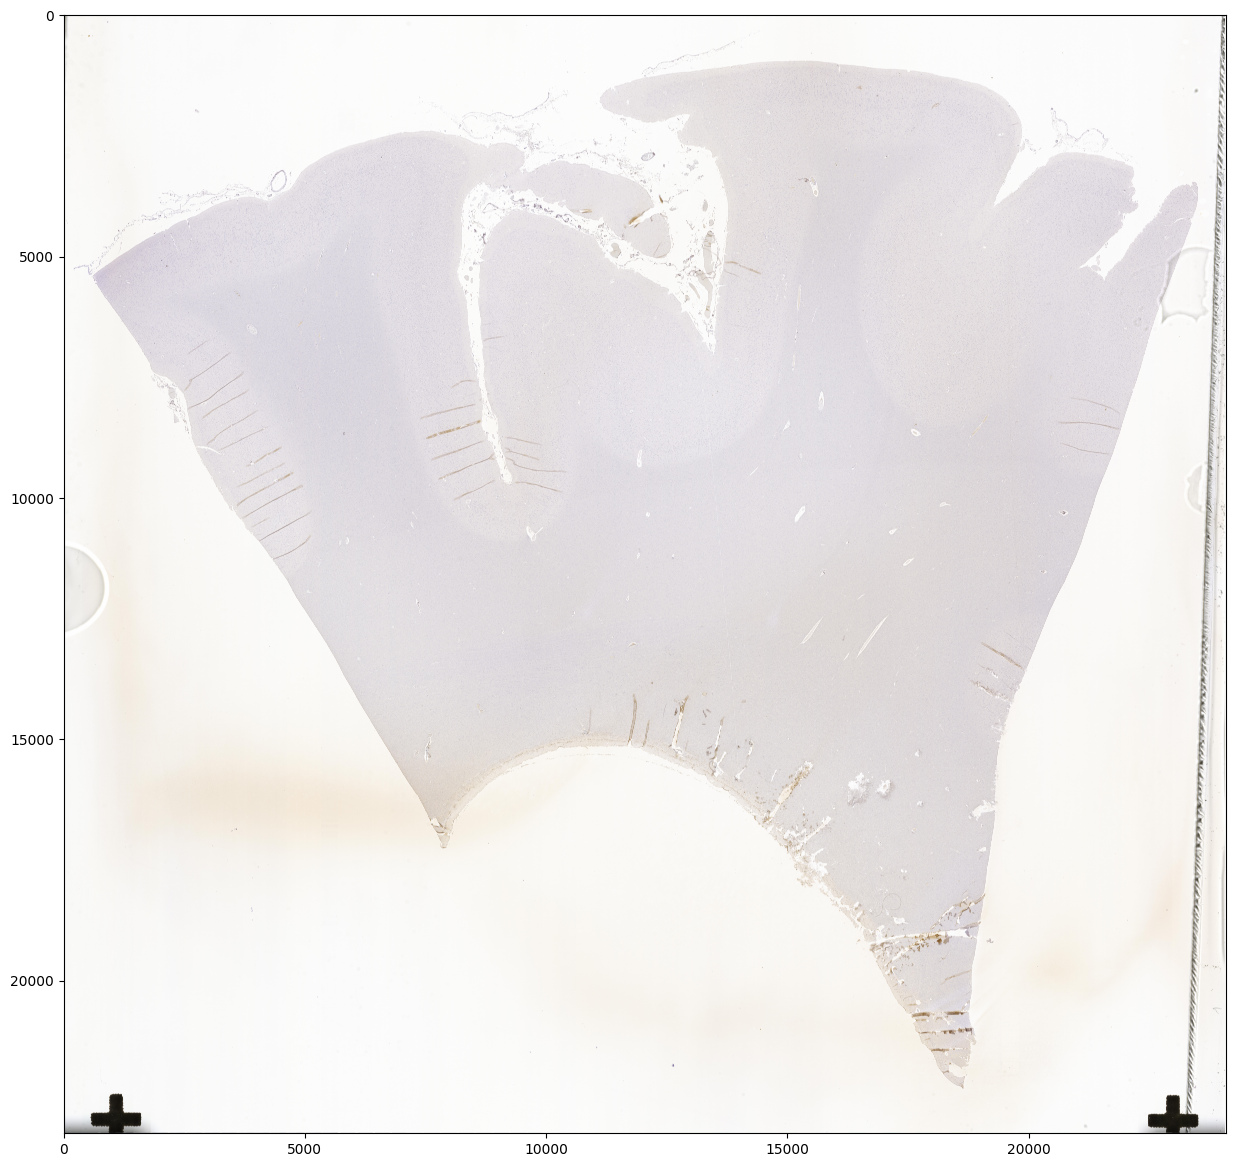

In [132]:

from __future__ import print_function

import histomicstk as htk

import pyvips as pv

import numpy as np
import scipy as sp

from skimage import io
import skimage.measure
import skimage.color

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24
imInput = pv.Image.new_from_file('/home/mjbarrett/Downloads/LR10_N179_S18_Large_SOX2.jpg').numpy()

# specify stains of input image
stains = ['hematoxylin',  
          'dab',    
          'null']      
# mask garbage
def intenseThreshPercent(img,lower_thresh,upper_thresh,lower_std=float("-inf"),upper_std=float("inf"), invert=False):
    img_std = img.std(axis=2)

    map_std = np.bitwise_and(img_std > lower_std, img_std < upper_std)

    img = skimage.color.rgb2gray(imInput)
    map = np.bitwise_and(img > lower_thresh, img < upper_thresh)

    map = np.bitwise_and(map, map_std)
    if invert:
        imInput[map == 0] = [255,255,255]
    else:
        imInput[map > 0] = [255,255,255]

# intenseThreshPercent(imInput, .92, 1, lower_std=16)
# intenseThreshPercent(imInput, 0, .12)

print(imInput.shape)
#dark

plt.imshow(imInput)

# normal deconv (matrix provided)

In [133]:
import histomicstk as htk
from histomicstk.preprocessing.color_deconvolution import stain_color_map
W = np.array([stain_color_map[st] for st in stains]).T
imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(imInput, W)
# Display results
for i in 0, 1:
    plt.figure()
    plt.imshow(imDeconvolved.Stains[:, :, i])
    _ = plt.title(stains[i], fontsize=titlesize)

: 

: 

[[255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 ...
 [255 255 255 ...   0   0 255]
 [255 255 255 ...   0   0 255]
 [255 255 255 ...   0   0   0]]
[[255 255 255 ...   0   0 255]
 [255 255 255 ...   0   0 255]
 [255 255 255 ...   0   0 255]
 ...
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]]


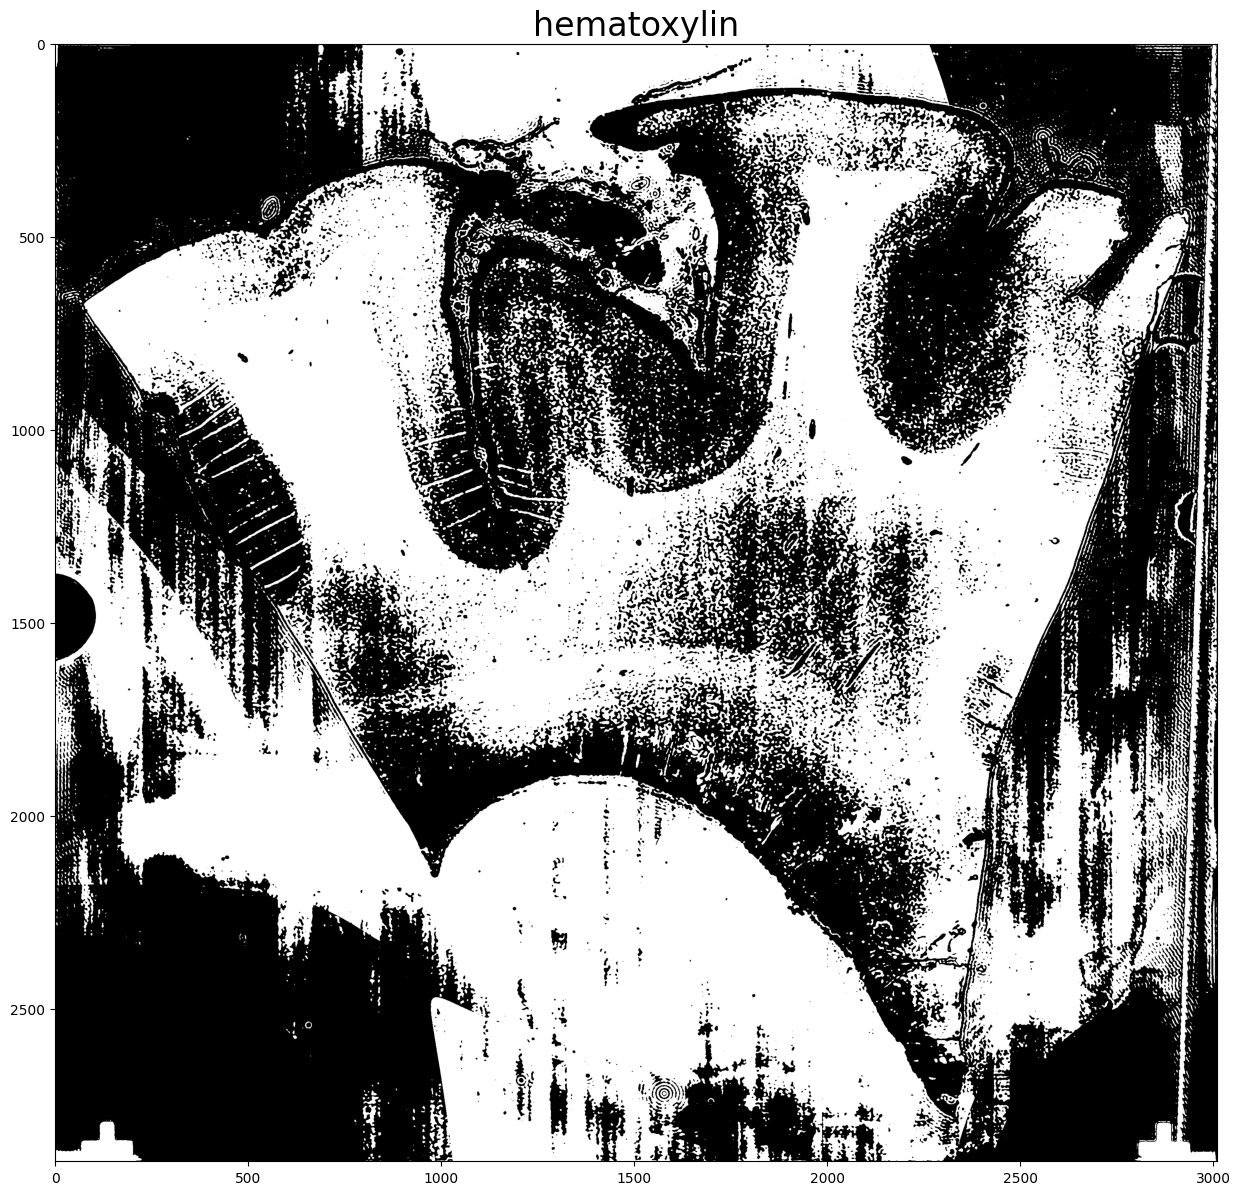

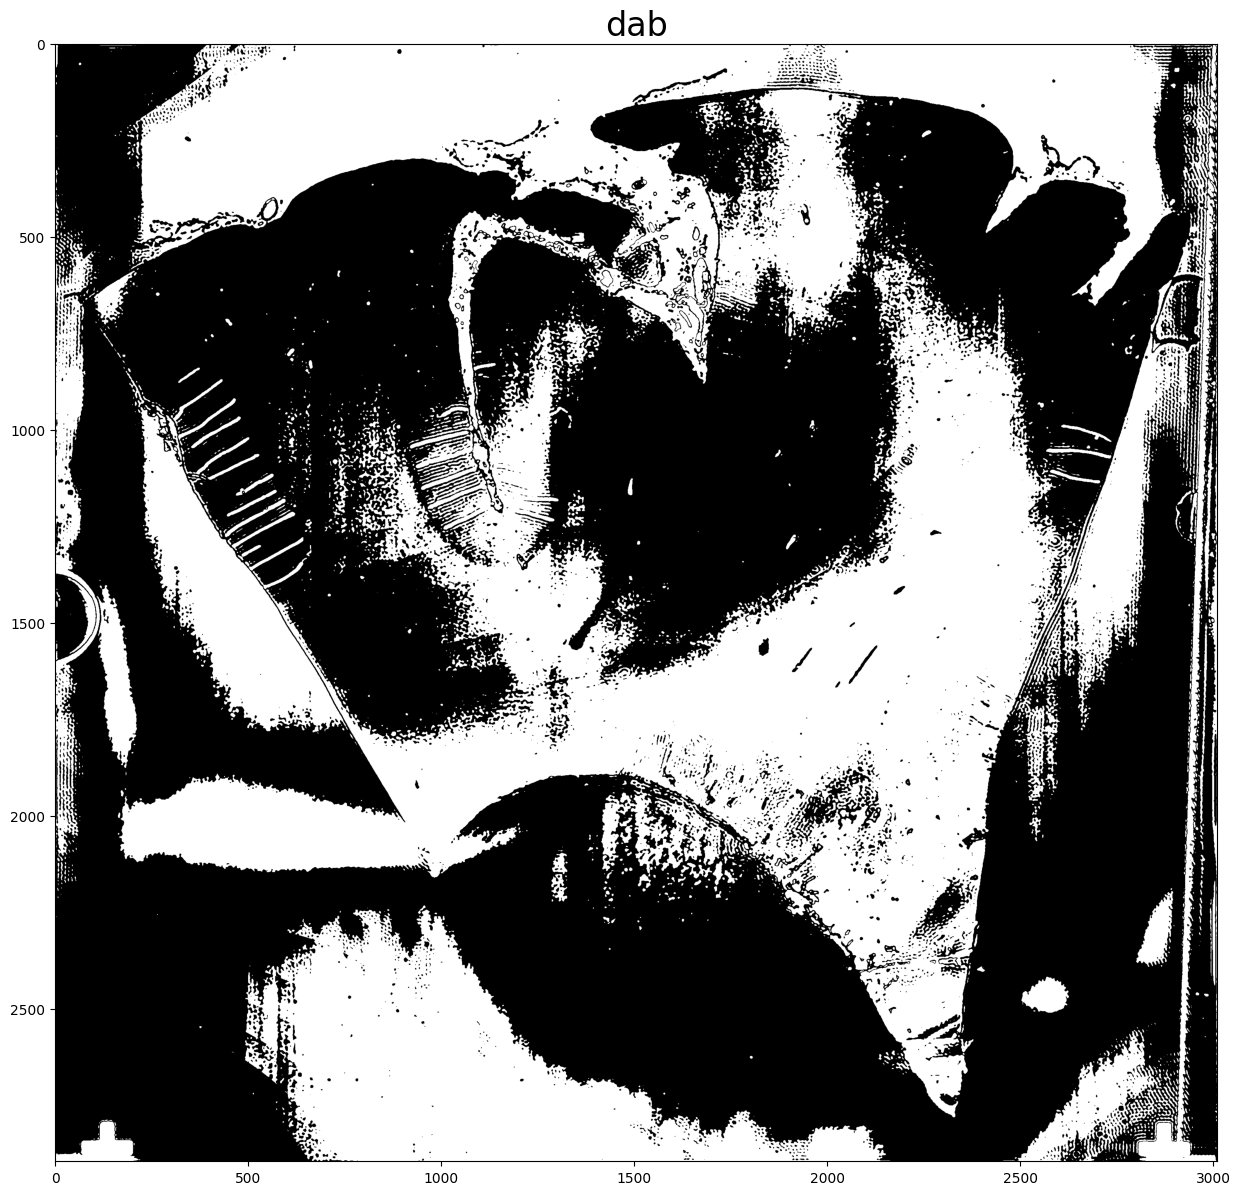

In [ ]:
from scipy.ndimage import gaussian_filter
from scipy.fftpack import fftshift, ifftshift, fft2, ifft2
from skimage.draw import polygon
import cv2

def threshold_nonzero(image):
    # Check if the image is color and convert to grayscale if needed
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Create a binary mask where all nonzero pixels are set to 255
    binary_mask = np.where(image < 1, 0, 1)

    return binary_mask

def bandpass_filter(image, low_ratio=0.00000000000001, high_ratio=0.16):
    # Preprocessing: Gaussian blur for noise reduction
    image = cv2.GaussianBlur(image, (5, 5), 0)

    # Fourier Transform
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)

    # Determine cutoff frequencies based on the image's dimensions
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    radius = np.sqrt(crow**2 + ccol**2)
    low_cutoff = radius * low_ratio
    high_cutoff = radius * high_ratio

    # Create a circular mask for bandpass filtering
    mask = np.zeros((rows, cols), np.uint8)
    r, c = np.ogrid[-crow:rows-crow, -ccol:cols-ccol]
    mask_area = np.logical_and(r**2 + c**2 >= low_cutoff**2, r**2 + c**2 <= high_cutoff**2)
    mask[mask_area] = 1

    # Apply the mask
    fshift = fshift * mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return img_back
    # Normalize to [0, 255]
    img_back = cv2.normalize(img_back, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    # Contrast stretching
    # min_intensity = np.min(img_back)
    # max_intensity = np.max(img_back)
    # img_back = ((img_back - min_intensity) / (max_intensity - min_intensity)) * 255
    # return img_back
    # Thresholding using Otsu's method
    # Determine blockSize based on image width
    block_size_ratio = 0.8
    block_size = int(image.shape[1] * block_size_ratio)
    block_size = block_size + 1 if block_size % 2 == 0 else block_size

    # Determine C based on standard deviation
    C_value = np.std(img_back) * 0.00001

    # Apply adaptive thresholding
    binary_mask = cv2.adaptiveThreshold(img_back.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, C_value)

    return binary_mask

stain_channel_1 = imDeconvolved.Stains[:,:,0]
stain_channel_2 = imDeconvolved.Stains[:,:,1]
stain_channel_3 = imDeconvolved.Stains[:,:,2]
rv = [bandpass_filter(stain_channel_1), bandpass_filter(stain_channel_2)]
for i in 0, 1:
    plt.figure()
    example =rv[i]
    print(example)
    plt.imshow(example, cmap='gray')
    _ = plt.title(stains[i], fontsize=titlesize)

In [129]:
from skimage.feature import graycomatrix, graycoprops
from skimage.filters import threshold_otsu
from scipy.cluster.vq import kmeans, vq
from skimage.util import view_as_blocks
import numpy as np

# Assuming imDeconvolved.Stains is your deconvolved image
stain_channel_1 = imDeconvolved.Stains[:,:,0]
stain_channel_2 = imDeconvolved.Stains[:,:,1]

# Texture Analysis
def get_texture_features(channel):
    glcm = graycomatrix(channel.astype(int), distances=[1], angles=[0], levels=256)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    return contrast
# small chunks to derive texture features
def split_into_blocks(image, block_size):
    blocks = []
    for row in np.array_split(image, range(block_size, image.shape[0], block_size), axis=0):
        for block in np.array_split(row, range(block_size, image.shape[1], block_size), axis=1):
            blocks.append(block)
    return blocks
# Process each channel separately
def process_channel(channel, block_size):
    blocks = split_into_blocks(channel, block_size)
    features = np.array([(get_texture_features(block)) 
                for block in blocks], dtype=np.float64)

    centroids, _ = kmeans(features, 3,thresh=.0001, iter=1) # 3 clusters for background, tissue, haze
    cluster_labels, _ = vq(features, centroids)
    return cluster_labels

block_size = 32  # Adjust as needed

# Process both channels
cluster_labels1 = process_channel(stain_channel_1, block_size)
cluster_labels2 = process_channel(stain_channel_2, block_size)

# Number of blocks along each dimension
num_blocks_row = stain_channel_1.shape[0] // block_size
num_blocks_col = stain_channel_1.shape[1] // block_size
# catch the remainder
if stain_channel_1.shape[0] % block_size != 0:
    num_blocks_row += 1
if stain_channel_1.shape[1] % block_size != 0:
    num_blocks_col += 1

# Visualization
plt.imshow(cluster_labels2.reshape(num_blocks_row , num_blocks_col ), cmap='jet')
plt.show()

KeyboardInterrupt: 

In [ ]:
from skimage.segmentation import felzenszwalb
import matplotlib.pyplot as plt

stain_channel = imDeconvolved.Stains[:,:,1]
# Assuming stain_channel is your specific stain channel of interest
min_size = int(stain_channel.shape[0] * stain_channel.shape[1] *.001) # .1% of the image size
segments = felzenszwalb(stain_channel, sigma=0,scale=50, min_size=min_size)

# Visualizing the results
plt.imshow(segments, cmap='jet')
plt.show()

In [ ]:
from scipy.stats import mode

# Calculate the size of each segment
label_sizes = [np.sum(segments == label) for label in np.unique(segments)]

# Find the indices of the two largest labels
largest_labels_idx = np.argsort(label_sizes)[-2:]

# Get the actual labels corresponding to the largest sizes
largest_labels = np.unique(segments)[largest_labels_idx]

# Find the mode of the two largest labels (or you could pick one manually)
merged_label = mode(segments[(segments == largest_labels[0]) | (segments == largest_labels[1])])[0][0]

# Merge the two largest labels into one
segments[(segments == largest_labels[0]) | (segments == largest_labels[1])] = merged_label

# Visualize the segments after merging
plt.imshow(segments, cmap='jet')
plt.show()


In [3]:
from concurrent.futures import ProcessPoolExecutor
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
from skimage.segmentation import felzenszwalb
import matplotlib.pyplot as plt
import numpy as np
import os
import logging

# Define distance metrics
distance_metrics = [
    # 'braycurtis', 
    # 'canberra', 
    'chebyshev', 'cityblock', 'correlation',
    'euclidean', 'jensenshannon', 'mahalanobis', 'minkowski', 'seuclidean',
    'sqeuclidean', 'wminkowski'
]

# Define linkage methods
linkage_methods = [
    'single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward'
]
import gc
# Define felzenszwalb parameters
sigmas = [0, 0.001, 0.1, 1, 2]
scales = [20, 50, 100, 150, 200, 500]
min_size_factors = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]

def process_combination(method, metric, sigma, scale, min_size_factor):
    gc.collect()
    stain_channel = imDeconvolved.Stains[:, :, 1]
    min_size = int(stain_channel.shape[0] * stain_channel.shape[1] * min_size_factor)
    segments = felzenszwalb(stain_channel, sigma=sigma, scale=scale, min_size=min_size)

    # Calculate mean intensity for each segment
    segment_means = [np.mean(stain_channel[segments == label]) for label in np.unique(segments)]
    max_clusters = 5  # Limit the number of segments

    # Compute the distance matrix
    distance_matrix = pdist(np.array(segment_means).reshape(-1, 1), metric=metric)

    # Perform hierarchical clustering on the distance matrix
    Z = linkage(distance_matrix, method=method)
    cluster_labels = fcluster(Z, max_clusters, criterion='maxclust')

    # Merge segments based on cluster labels
    merged_segments = np.zeros_like(segments)
    for i, label in enumerate(np.unique(segments)):
        merged_segments[segments == label] = cluster_labels[i]

    # Visualize the merged segments
    output_directory = f"./segmentations/{method}/{metric}"
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    output_path = os.path.join(output_directory, f'felzenszwalb_{sigma}_{scale}_{min_size}.jpg')
    plt.title(f'Merged segments using {metric} metric, {method} method, sigma={sigma}, scale={scale}')
    plt.imshow(merged_segments, cmap='jet')
    plt.savefig(output_path)
    plt.close('all')

    logging.error(f'Saved image using {metric} metric, {method} method, sigma={sigma}, scale={scale} to {output_path}')

# Create a pool of worker processes
with ProcessPoolExecutor(4) as executor:
    futures = []
    for method in linkage_methods:
        for metric in distance_metrics:
            for sigma in sigmas:
                for scale in scales:
                    for min_size_factor in min_size_factors:
                        # Submit each combination to the process pool
                        futures.append(executor.submit(process_combination, method, metric, sigma, scale, min_size_factor))

    # Wait for all processes to complete
    for future in futures:
        future.result()

ERROR:root:Saved image using chebyshev metric, single method, sigma=0, scale=20 to ./segmentations/single/chebyshev/felzenszwalb_0_20_8716.jpg
ERROR:root:Saved image using chebyshev metric, single method, sigma=0, scale=20 to ./segmentations/single/chebyshev/felzenszwalb_0_20_871.jpg
ERROR:root:Saved image using chebyshev metric, single method, sigma=0, scale=20 to ./segmentations/single/chebyshev/felzenszwalb_0_20_87168.jpg
ERROR:root:Saved image using chebyshev metric, single method, sigma=0, scale=20 to ./segmentations/single/chebyshev/felzenszwalb_0_20_871684.jpg
ERROR:root:Saved image using chebyshev metric, single method, sigma=0, scale=20 to ./segmentations/single/chebyshev/felzenszwalb_0_20_87.jpg
ERROR:root:Saved image using chebyshev metric, single method, sigma=0, scale=50 to ./segmentations/single/chebyshev/felzenszwalb_0_50_871.jpg
ERROR:root:Saved image using chebyshev metric, single method, sigma=0, scale=50 to ./segmentations/single/chebyshev/felzenszwalb_0_50_8716.jpg


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
from skimage.segmentation import felzenszwalb
import matplotlib.pyplot as plt
import numpy as np
import os

# Define distance metrics
distance_metrics = [
    'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation',
    'euclidean', 'jensenshannon', 'mahalanobis', 'minkowski', 'seuclidean',
    'sqeuclidean', 'wminkowski'
]

# Define linkage methods
linkage_methods = [
    'single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward'
]

# Define felzenszwalb parameters
sigmas = [0, 0.001, 0.1, 1, 2]
scales = [20, 50, 100, 150, 200, 500]
min_size_factors = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]

# Loop through the linkage methods
for method in linkage_methods:
    for metric in distance_metrics:
        for sigma in sigmas:
            for scale in scales:
                for min_size_factor in min_size_factors:
                    stain_channel = imDeconvolved.Stains[:, :, 1]
                    min_size = int(stain_channel.shape[0] * stain_channel.shape[1] * min_size_factor)
                    segments = felzenszwalb(stain_channel, sigma=sigma, scale=scale, min_size=min_size)

                    # Calculate mean intensity for each segment
                    segment_means = [np.mean(stain_channel[segments == label]) for label in np.unique(segments)]
                    max_clusters = 5  # Limit the number of segments

                    # Compute the distance matrix
                    distance_matrix = pdist(np.array(segment_means).reshape(-1, 1), metric=metric)

                    # Perform hierarchical clustering on the distance matrix
                    Z = linkage(distance_matrix, method=method)
                    cluster_labels = fcluster(Z, max_clusters, criterion='maxclust')

                    # Merge segments based on cluster labels
                    merged_segments = np.zeros_like(segments)
                    for i, label in enumerate(np.unique(segments)):
                        merged_segments[segments == label] = cluster_labels[i]

                    # Visualize the merged segments
                    output_directory = f"./segmentations/{method}/{metric}"
                    if not os.path.exists(output_directory):
                        os.makedirs(output_directory)

                    output_path = os.path.join(output_directory, f'felzenszwalb_{sigma}_{scale}_{min_size}.jpg')
                    plt.title(f'Merged segments using {metric} metric, {method} method, sigma={sigma}, scale={scale}')
                    plt.imshow(merged_segments, cmap='jet')
                    plt.savefig(output_path)
                    plt.close()

                    print(f'Saved image using {metric} metric, {method} method, sigma={sigma}, scale={scale} to {output_path}')


In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist, squareform

# Calculate mean intensity for each segment
segment_means = [np.mean(stain_channel[segments == label]) for label in np.unique(segments)]

# Compute the distance matrix
distance_matrix = pdist(np.array(segment_means).reshape(-1, 1), metric='canberra')

# Perform hierarchical clustering on the distance matrix
Z = linkage(distance_matrix, method='ward')
max_clusters = 5  # You can set this to limit the number of segments
cluster_labels = fcluster(Z, max_clusters, criterion='maxclust')

# Merge segments based on cluster labels
merged_segments = np.zeros_like(segments)
for i, label in enumerate(np.unique(segments)):
    merged_segments[segments == label] = cluster_labels[i]

# Visualize the merged segments
plt.imshow(merged_segments, cmap='jet')
plt.show()


In [ ]:
from skimage.feature import greycomatrix, greycoprops

# Define a function to calculate GLCM features
def calculate_glcm_features(channel):
    glcm = greycomatrix(channel, [10], [0], symmetric=True, normed=True)
    return {
        'contrast': greycoprops(glcm, 'contrast'),
        'homogeneity': greycoprops(glcm, 'homogeneity'),
        'energy': greycoprops(glcm, 'energy'),
        'correlation': greycoprops(glcm, 'correlation'),
    }

# Define a function to calculate the difference in textures between channels
def calculate_texture_difference(texture1, texture2):
    return {key: abs(texture1[key] - texture2[key]) for key in texture1}

# Get the shape of the deconvolved image
height, width, channels = imDeconvolved.Stains.shape

# Calculate GLCM features for each channel
textures = [calculate_glcm_features(imDeconvolved.Stains[:,:,c]) for c in range(channels)]

# Calculate differences in textures between the channels
texture_differences = [calculate_texture_difference(textures[i], textures[j]) for i in range(channels) for j in range(i+1, channels)]

# Define a threshold to identify significant differences in textures (you may need to tune this value)
texture_difference_threshold = {'contrast': 10, 'homogeneity': 0.1, 'energy': 0.1, 'correlation': 0.1}

# Create a mask based on the differences in textures
mask = np.zeros((height, width), dtype=bool)
for diff in texture_differences:
    for feature, threshold in texture_difference_threshold.items():
        print(f'{feature}: {diff[feature]}')
        mask |= diff[feature] > threshold

# Plot the mask alongside the original channels
plt.figure(figsize=(12, 6))
plt.subplot(1, channels+1, 1)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')

for c in range(channels):
    plt.subplot(1, channels+1, c+2)
    plt.imshow(imDeconvolved.Stains[:,:,c], cmap='gray')
    plt.title(f'Channel {c}')
    plt.axis('off')

plt.show()


In [ ]:
import cv2
dab = imDeconvolved.Stains[:, :, 1]
print(dab)
dab_th = cv2.threshold(dab, 256*.8, 255, cv2.THRESH_BINARY)
print(dab_th)

In [ ]:
plt.imshow(dab_th[1])

# pca based deconvolution (only works for images with two stains)

In [ ]:

I_0 = 255
print(stain_color_map)
w_est = htk.preprocessing.color_deconvolution.rgb_separate_stains_macenko_pca(imInput, I_0)
print(w_est)
# Perform color deconvolution
deconv_result = htk.preprocessing.color_deconvolution.color_deconvolution(imInput, w_est, I_0)

print('Estimated stain colors (rows):', w_est.T[:2], sep='\n')

# Display results
for i, color in (1,'copper_r'), (0,"Blues_r"):
    plt.figure()
    # Unlike SNMF, we're not guaranteed the order of the different stains.
    # find_stain_index guesses which one we want
    print(stain_color_map[stains[i]])
    channel = htk.preprocessing.color_deconvolution.find_stain_index(
        stain_color_map[stains[i]], w_est)
    print(channel)
    
    plt.imshow(deconv_result.Stains[:, :, channel], cmap=color)
    _ = plt.title(stains[i], fontsize=titlesize)

In [ ]:
# Import required modules
import configparser
from histoqc import config, BaseImage
from histoqc._pipeline import load_pipeline
import matplotlib.pyplot as plt
import numpy as np
from omero.gateway import BlitzGateway
from IPython.display import clear_output

# Set up configuration
hqc_config =  configparser.ConfigParser()
hqc_config.read_string(config.read_config_template("prostate.HE"))

# test out pipeline
# Extract parameters from the config file
params = {
    "image_work_size": hqc_config.get("BaseImage.BaseImage", "image_work_size"),
    "in_memory_compression": hqc_config.get("BaseImage.BaseImage", "in_memory_compression"),
    "mask_statistics": hqc_config.get("BaseImage.BaseImage", "mask_statistics"),
    # Add any other parameters that you need
}

with BlitzGateway('mjbarrett', 'gzyxby01', host='wsi.lavlab.mcw.edu', secure=True) as conn:
    base_image = BaseImage.BaseImage("Jupyter notebook", conn, 3087, ".", params)
    
    prev_mask = None
    prev_image = None
    for func, kwargs in load_pipeline(hqc_config):
        print(func, kwargs)
        try:
            await func(base_image, kwargs)
        except:
            pass
        
        # Get current mask and image
        image_data = base_image.getImgThumb(base_image["image_work_size"])[0]
        mask= np.stack([base_image['img_mask_use']]*image_data.shape[2], axis=-1)

        # apply mask
        image_date = np.where(mask==1, image_data, mask)

        # Display previous and current masks and images
        plt.figure(figsize=(8,8))  # Adjust as needed
        if prev_mask is not None and prev_image is not None:
            plt.subplot(2, 2, 1)
            plt.imshow(prev_mask*255)
            plt.title('Previous mask')
            plt.subplot(2, 2, 2)
            plt.imshow(prev_image)
            plt.title('Previous image')
        plt.subplot(2, 2, 3)
        plt.imshow(mask*255)
        plt.title('Current mask')
        plt.subplot(2, 2, 4)
        plt.imshow(np.where(mask==1, image_data, mask))
        plt.title('Current image')
        plt.tight_layout()
        plt.show()

        input("Press Enter to continue to the next step...")

        # Clear the previous output
        clear_output(wait=False)
        # Store the current mask and image for the next iteration
        prev_mask = mask.copy()
        prev_image = np.where(mask==1, image_data, mask).copy()


In [ ]:
import configparser
from histoqc import config, BaseImage
from histoqc._pipeline import load_pipeline
import matplotlib.pyplot as plt
import numpy as np
from omero.gateway import BlitzGateway
from IPython.display import clear_output

import matplotlib.pyplot as plt

# Set up configuration
hqc_config =  configparser.ConfigParser()
hqc_config.read_string(config.read_config_template("prostate.HE"))

# test out pipeline
# Extract parameters from the config file
params = {
    "image_work_size": hqc_config.get("BaseImage.BaseImage", "image_work_size"),
    "in_memory_compression": hqc_config.get("BaseImage.BaseImage", "in_memory_compression"),
    "mask_statistics": hqc_config.get("BaseImage.BaseImage", "mask_statistics"),
    # Add any other parameters that you need
}

with BlitzGateway('mjbarrett', 'gzyxby01', host='wsi.lavlab.mcw.edu', secure=True) as conn:
    base_image = BaseImage.BaseImage("Jupyter notebook", conn, 463, ".", params)
    
    fig, axs = plt.subplots(len(load_pipeline(hqc_config)), 2, figsize=(10, len(load_pipeline(hqc_config))*5))  # Adjust as needed
    for i, (func, kwargs) in enumerate(load_pipeline(hqc_config)):
        print(func, kwargs)
        try:
            await func(base_image, kwargs)
        except:
            pass

        # Get current mask and image
        image_data = base_image.getImgThumb(base_image["image_work_size"])[0]
        mask= np.stack([base_image['img_mask_use']]*image_data.shape[2], axis=-1)

        axs[i, 0].imshow(mask*255)
        axs[i, 0].set_title(f'Step {i+1}: Mask')
        axs[i, 1].imshow(np.where(mask==1, image_data, mask))
        axs[i, 1].set_title(f'Step {i+1}: Image')

    plt.tight_layout()
    plt.show()

